# Data Valuation with Nearest Neighbor Explainers

This notebook shows how explainers of nearest-neighbor (NN) models can be used for Data Valuation, the task of evaluating the usefulness of individual training data points in classification problems.
When explaining NN models, a game is defined by first choosing an explanation point $x_\text{explain}$ and class $y_\text{explain}$; the training data points $\mathcal{D} := \mathcal{X} \times \mathcal{Y}$ are the game's players, and the definition of the utility $\nu(S)$ of a coalition $S \subseteq \mathcal{D}$ is based on the probability of the model predicting class $y_\text{explain}$ on $x_\text{explain}$ if it's training data were limited to $S$.

There is support for explaining the the `KNeighborsClassifier` model (with `'uniform'` or `'distance'` weights) and `RadiusNeighborsClassifier` model from the `scikit-learn` library.
The algorithms are based on the publications from [Jia et al. (2019)](https://doi.org/10.48550/arXiv.1908.08619/), [Wang et al. (2024)](https://doi.org/10.48550/arXiv.1908.08619)
and [Wang et al. (2023)](https://doi.org/10.48550/arXiv.2308.15709), respectively.

Let's start by generating a synthetic classification datset and fitting a simple `KNeighborsClassifier` to it.

Prediction: class 0
Prediction probabilities: [0.66666667 0.33333333]


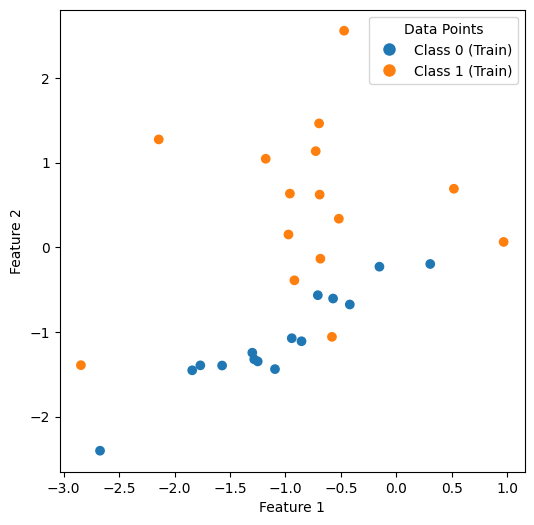

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from plot_helpers import plot_datasets
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier

X_train, y_train = make_classification(
    n_samples=30,
    n_features=2,
    n_redundant=0,
    n_clusters_per_class=1,
    n_informative=2,
    n_classes=2,
    random_state=45,
)

fig, ax = plt.subplots(figsize=(6, 6))
plot_datasets(ax, X_train, y_train)

model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)

x_explain = np.array([[-0.75, -0.4]])
y_explain_pred = model.predict(x_explain)[0]
print(f"Prediction: class {y_explain_pred}")

y_explain_proba = model.predict_proba(x_explain)[0]
print(f"Prediction probabilities: {y_explain_proba}")

## Using the `KNNExplainer` for Unweighted $k$-Nearest Neighbor Models

To explain the prediction, we create an explainer for the model by passing it to the constructor of `Explainer`, which will automatically dispatch to the adequate subclass `KNNExplainer`.

In [2]:
from shapiq import Explainer

explainer = Explainer(model, class_index=y_explain_pred, max_order=1)
print(type(explainer))

<class 'shapiq.explainer.nn.knn.KNNExplainer'>


Note that we set `class_index=y_explain_pred`, since for now, we want to quantify the contribution of the training data to the class that was actually predicted. (We could also set a different class index if we wished to see how much the data points contribute to shifting the prediction towards another class.)

Now we can get an explanation for the prediction we saw above:

In [3]:
iv = explainer.explain(x_explain)
print(iv)

InteractionValues(
    index=SV, max_order=1, min_order=1, estimated=True, estimation_budget=None,
    n_players=30, baseline_value=0,
    Top 10 interactions:
        (9,): 0.20212345126138226
        (23,): 0.20212345126138226
        (2,): 0.11879011792804894
        (14,): 0.08545678459471562
        (15,): 0.06759964173757277
        (28,): 0.06759964173757277
        (16,): 0.058508732646663675
        (19,): -0.08120988207195104
        (1,): -0.13120988207195106
        (4,): -0.13120988207195106
)


### Large number of training samples

Since the algorithm is pretty efficient, with a runtime complexity of $O(N \log N)$, we can run it on large sets of training data. (The cell below takes roughly 0.5 s to explain a single data point on a consumer-grade laptop with a 12th Gen Intel i5 processor.)

In [ ]:
from time import time


def print_explain_times(model, n, n_test) -> None:
    X_train, y_train = make_classification(
        n_samples=n,
        n_features=5,
        n_redundant=0,
        n_clusters_per_class=1,
        n_informative=3,
        n_classes=2,
        random_state=45,
    )
    X_test = X_train[:n_test]
    X_train = X_train[n_test:]
    y_train = y_train[n_test:]
    model.fit(X_train, y_train)
    explainer = Explainer(model, class_index=0, max_order=1)

    times = np.zeros((n_test,))
    for i, x_test in enumerate(X_test):
        t_start = time()
        explainer.explain(x_test)
        t_end = time()
        times[i] = t_end - t_start
    mean = np.mean(times) * 1000
    std = np.std(times) * 1000
    print(f"{mean:.1f}±{std:.1f}ms")

In [ ]:
print_explain_times(KNeighborsClassifier(n_neighbors=5), n=100_000, n_test=50)

458.2±32.8ms


## Explaining Weighted $k$-Nearest Neighbor and Threshold Nearest Neighbor Models

There are separate explainers for weighted $k$-NN and threshold NN models, which are selected automatically when an `Explainer` is instantiated with a corresponding model:

In [6]:
wknn_model = KNeighborsClassifier(n_neighbors=3, weights="distance")
wknn_model.fit(X_train, y_train)
wknn_explainer = Explainer(wknn_model, max_order=1)
print(type(wknn_explainer))

tnn_model = RadiusNeighborsClassifier()
tnn_model.fit(X_train, y_train)
tnn_explainer = Explainer(tnn_model, max_order=1)
print(type(tnn_explainer))

<class 'shapiq.explainer.nn.weighted_knn.WeightedKNNExplainer'>
<class 'shapiq.explainer.nn.threshold_nn.ThresholdNNExplainer'>


They can be used just the same way:

In [7]:
print(wknn_explainer.explain(x_explain))
print(tnn_explainer.explain(x_explain))

ValueError: X has 2 features, but KNeighborsClassifier is expecting 5 features as input.

## Identifying corrupted training samples

We can estimate the usefulness of each point of a training data set by calculating Shapley values for a set of test data points and averaging the results. This will allow us to identify potentially mislabeled data points.

First, let's create a classification data set and split it into train and test sets. We will corrupt the training data by changing the class of a few randomly selected data points.

In [ ]:
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=100,
    n_features=2,
    n_redundant=0,
    n_clusters_per_class=1,
    n_informative=2,
    n_classes=2,
    flip_y=0,
    random_state=49,
    class_sep=1.5,
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

y_train_corrupted = y_train.copy()
n_corrupt = 7
rng = np.random.default_rng(seed=43)
corrupted = rng.choice(np.arange(X_train.shape[0]), size=n_corrupt, replace=False)
# Since our only class indices are 0 and 1, this is a quick way to flip the class
y_train_corrupted[corrupted] = 1 - y_train[corrupted]

fig, ax = plt.subplots(figsize=(6, 6))
plot_datasets(ax, X_train, y_train_corrupted, X_test, y_test)
# Mark corrupted datapoints
ax.scatter(
    X_train[corrupted, 0],
    X_train[corrupted, 1],
    marker="o",
    edgecolors="#b1170c",
    facecolors="none",
    s=100,
);

Now, we can use the `KNNExplainer` to compute the training points' Shapley values based on the entire test dataset by averaging the Shapley values computed using each test point.

In [ ]:
from shapiq.explainer.nn.iv_utils import interaction_values_to_array

# Train the model with the corrupted training data
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train_corrupted)

sv_test = np.zeros(X_train.shape[0], dtype=np.float64)

for x_test_current, y_test_current in zip(X_test, y_test, strict=True):
    explainer = Explainer(model, class_index=y_test_current, max_order=1)
    iv = explainer.explain(x_test_current)
    sv_current = interaction_values_to_array(iv)
    sv_test += sv_current

sv_test /= X_test.shape[0]

We can reasonably assume that the corrupted training data points will on average make the model's prediction worse, resulting in negative Shapley values. So let's filter out just those indices where the Shapley value is below zero and compare with our original array of corrupted indices:

In [ ]:
print(f"Corrupted: {np.sort(corrupted)}")  # Sort for easier comparison
print(f"Negative Shapley values: {np.where(sv_test < 0)[0]}")

We have identified the set corrupted samples almost exactly. The fact that the point with index 20 was missed, however, shows that this method is not failsafe but only an estimate.